In [1]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import pylab as plt
import json
import pycrs
import seaborn as sns

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import GOSTnet as gn
from pandana.loaders import osm;

from osgeo import gdal, gdalconst, gdal_array
from rasterstats import point_query, zonal_stats
from make_fishnet import make_fishnet

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 


In [2]:
boundary_GDF = ox.gdf_from_place('Kampala',which_result=2)
boundary_GDF
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon

In [3]:
pop_raster = rasterio.open('data/kampala_pop_2.tiff')
coords = (pop_raster.bounds[1], pop_raster.bounds[0], pop_raster.bounds[3], pop_raster.bounds[2])

In [4]:
path = 'data'
tif_10_proj_path = os.path.join(path, '10yr_Kampala_proj.tif')
tif_50_proj_path = os.path.join(path, '50yr_Kampala_proj.tif')
tif_100_proj_path = os.path.join(path, '100yr_Kampala_proj.tif')

#### 3. Sample rasters for flood depth

In [5]:
# Create graph
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

In [6]:
from shapely.geometry import Point
from shapely.geometry import LineString

node_dict = {}

G2 = G.copy()

for u, data in G2.nodes(data = True):
    node_dict[u] = Point(data['x'],data['y'])
        
for u, v, data in G2.edges(data = True):
    
    if 'Wkt' not in data.keys():
        strt = node_dict[u]
        fini = node_dict[v]
        data['Wkt'] = LineString([strt, fini])
    
    if 'geometry' in data.keys():
        data['Wkt'] = data['geometry']
        data.pop('geometry')

In [7]:
importlib.reload(gn)
G3 = gn.salt_long_lines(G2,
                       source = 'epsg:4326',
                      target = 'epsg:32636',
                      thresh = 50,
                      factor = 1)

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 12164 unique edge(s) longer than 50. 
Beginning new node creation...
80246 new edges added and 23857 removed to bring total edges to 88057
27959 new nodes added to bring total nodes to 41659


In [8]:
G3 = gn.sample_raster(G3, tif_10_proj_path, property_name = 'flood_depth_10_yr')
G3 = gn.sample_raster(G3, tif_50_proj_path, property_name = 'flood_depth_50_yr')
G3 = gn.sample_raster(G3, tif_100_proj_path, property_name = 'flood_depth_100_yr')

In [15]:
gn.example_node(G3)

(6241026052, {'y': 0.3487386, 'x': 32.5916098, 'osmid': 6241026052, 'flood_depth_10_yr': -32767.0, 'flood_depth_50_yr': -32767.0, 'flood_depth_100_yr': -32767.0})


#### 4. Create the degraded road networks

In [16]:
node_gdf = gn.node_gdf_from_graph(G3)
edge_gdf = gn.edge_gdf_from_graph(G3)

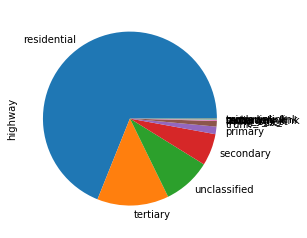

In [17]:
edge_gdf.highway[:5000].value_counts().plot(kind='pie')

In [161]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':25,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

speed_dict_flooded = { 'residential': 17, 'primary': 35, 'primary_link':31, 'motorway':40, 'motorway_link': 35, 'trunk': 35, 'trunk_link':31.5, 'secondary': 28.5, 'secondary_link':22, 'tertiary':22, 'tertiary_link': 22, 'unclassified':19, 'road':19, 'crossing':19, 'living_street':19 }

In [92]:
G3 = gn.convert_network_to_time(G3, distance_tag = 'length', speed_dict = speed_dict)

In [162]:
G_flood10 = gn.convert_network_to_time(G3.copy(), distance_tag = 'length', speed_dict = speed_dict_flooded)
G_flood50 = gn.convert_network_to_time(G3.copy(), distance_tag = 'length', speed_dict = speed_dict_flooded)
G_flood100 = gn.convert_network_to_time(G3.copy(), distance_tag = 'length', speed_dict = speed_dict_flooded)

In [293]:
gdf_50 = gn.node_gdf_from_graph(G_flood50)

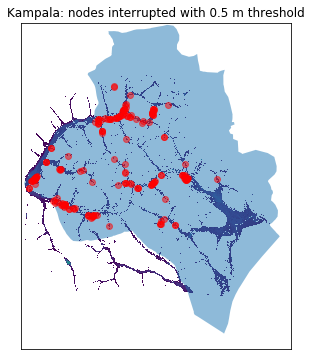

In [378]:
raster = rasterio.open(tif_50_proj_path)
ax = boundary_GDF.plot(alpha = 0.5, figsize=[6,6])
show(raster, ax = ax)
threshold=0.5

#grid_clipped.plot(ax=ax,alpha=0.5)
#POIs_health.plot(ax=ax,color='r')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.title('Kampala: nodes interrupted with {} m threshold'.format(threshold));
gdf_50[gdf_50.flood_depth_50_yr>threshold].plot(figsize=[8,8],color='r',ax=ax,alpha = 0.5)

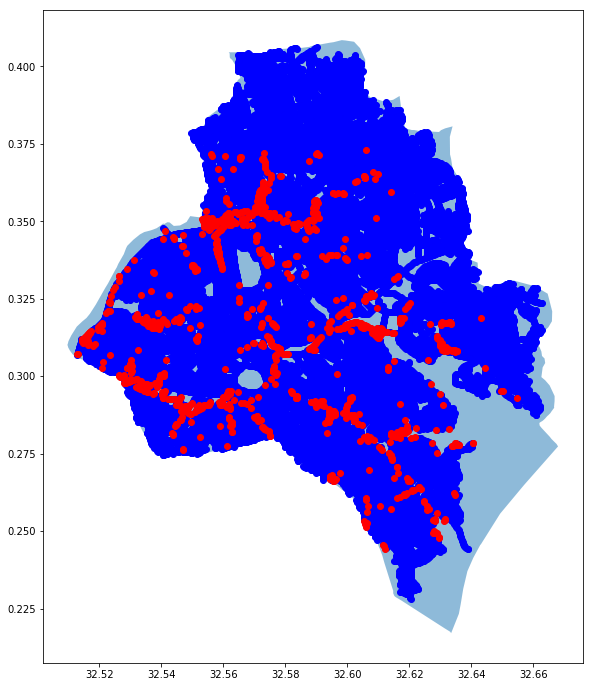

In [377]:
threshold = 0.15
ax = boundary_GDF.plot(alpha = 0.5, figsize=[12,12])
gdf_50[gdf_50.flood_depth_50_yr<threshold].plot(color='b',ax=ax)
gdf_50[gdf_50.flood_depth_50_yr>threshold].plot(color='r',ax=ax)

In [163]:
my_flood_depth = 0.15
fail_value = 999999999999999

print("10 year:")
G_flood10 = gn.disrupt_network(G_flood10, 'flood_depth_10_yr', my_flood_depth, fail_value)

print()
print("50 year:")
G_flood50 = gn.disrupt_network(G_flood50, 'flood_depth_50_yr', my_flood_depth, fail_value)

print()
print("100 year:")
G_flood100 = gn.disrupt_network(G_flood100, 'flood_depth_100_yr', my_flood_depth, fail_value)


10 year:
nodes disrupted: 917
edges disrupted: 2688

50 year:
nodes disrupted: 1236
edges disrupted: 3486

100 year:
nodes disrupted: 1377
edges disrupted: 3837


In [76]:
n_nodes = node_gdf.shape[0]
n_edges = edge_gdf.shape[0]
print("Threshold {} meters:".format(my_flood_depth))
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (919/n_nodes * 100, 2684/n_edges * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (1236/n_nodes * 100, 3480/n_edges * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (1377/n_nodes * 100, 3831/n_edges * 100))

Threshold 0.15 meters:
10-year flood disrupts 2.21 % of nodes and 3.05 % of edges
50-year flood disrupts 2.97 % of nodes and 3.95 % of edges
100-year flood disrupts 3.31 % of nodes and 4.35 % of edges


#### 6. Get origin points
* fishnet of the city
* sample of 307 firms from the employment survey

In [22]:
make_fishnet('grid_KM.shp',coords[1], coords[3], coords[0], coords[2],500,500) # takes xmin, xmax, ymin, ymax

In [79]:
grid=gpd.read_file('grid_KM.shp')

In [80]:
ES_points = gpd.read_file('data/points_ES_clipped')

#### 7. Get destinations (POIs and employment density)

In [81]:
# Hospitals

In [82]:
bbox = pop_raster.bounds

amenities_hospital = ['hospital']
POIs_health = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(amenities_hospital)))

POIs_health = POIs_health[['amenity','name','lat','lon']]
POIs_health = gpd.GeoDataFrame(POIs_health)
POIs_health['geometry'] = (list(zip(POIs_health.lon,POIs_health.lat)))
POIs_health['geometry'] = POIs_health.geometry.apply(lambda x: Point(x))

POIs_health = gpd.sjoin(POIs_health,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [27]:
# Business amenities (3300 businesses, stores, gas or mobile phone suppliers, from notebook 4)

In [83]:
POIs_biz = gpd.read_file('data/KM_pois/KM_biz_amenities1')

In [29]:
# Employment density points

In [84]:
employment_points = gpd.read_file('data/jobdensity_kampala_points.shp')
employment_points['percent_jobs'] = employment_points.density/ employment_points.density.sum() * 100

print("There are {} grid cells for the employment density data. Mean percent of total jobs in a grid cell is {:.3f} and largest is {:.2f}".format(
    employment_points.shape[0], employment_points.percent_jobs.mean(), employment_points.percent_jobs.max()))

There are 6228 grid cells for the employment density data. Mean percent of total jobs in a grid cell is 0.016 and largest is 2.33


#### 9. Snap Os and Ds to graph

In [246]:
grid['geometry'] = grid.centroid
grid.set_geometry('geometry',inplace=True)

In [247]:
grid = gn.pandana_snap(G3, grid)

/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1572: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1574: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [239]:
# Origins
ES_points = gn.pandana_snap(G3, ES_points)
grid = gn.pandana_snap(G3, grid)

# Destinations
POIs_biz = gn.pandana_snap(G3, POIs_biz)
employment_points = gn.pandana_snap(G3, employment_points)
POIs_health = gn.pandana_snap(G3, POIs_health)


/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1572: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/Users/nicholasjones/Desktop/code/network_analysis/GOSTnet.py:1574: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [87]:
list_of_nearest_nodes_ES = list(ES_points.NN)
#list_of_nearest_nodes_grid = list(grid_nn.NN)
list_of_nearest_nodes_POIs_biz = list(POIs_biz.NN)
list_of_nearest_nodes_employment_points = list(employment_points.NN)

## ANALYSIS

#### 10. Firm connectivity: travel time between ES points

In [34]:
baseline_OD_firms = gn.calculate_OD(G3, list(ES_points.NN), list(ES_points.NN), fail_value, weight='time')

In [164]:
flood_OD_firms_10yr = gn.calculate_OD(G_flood10, list(ES_points.NN), list(ES_points.NN), fail_value, weight='time')
flood_OD_firms_50yr = gn.calculate_OD(G_flood50, list(ES_points.NN), list(ES_points.NN), fail_value, weight='time')
flood_OD_firms_100yr = gn.calculate_OD(G_flood100, list(ES_points.NN), list(ES_points.NN), fail_value, weight='time')

In [165]:
travel_times_base = baseline_OD_firms[baseline_OD_firms < fail_value] / 60
travel_times_10 = flood_OD_firms_10yr[flood_OD_firms_10yr < fail_value] / 60
travel_times_50 = flood_OD_firms_50yr[flood_OD_firms_50yr < fail_value] / 60
travel_times_100 = flood_OD_firms_100yr[flood_OD_firms_100yr < fail_value] / 60

In [221]:
pd.Series(flood_OD_firms_10yr.ravel()).shape

(94249,)

In [230]:
travel_times_50.ravel().shape

(73795,)

In [232]:
(94249 - 73795) /94249 *100

21.70208702479602

In [166]:
gn.example_edge(G3)

(6241026052, 577386967, {'osmid': 278571313, 'highway': 'residential', 'oneway': False, 'length': 42.742000000000004, 'Wkt': <shapely.geometry.linestring.LineString object at 0x1a23206208>, 'time': 7.693560000000001, 'mode': 'drive'})


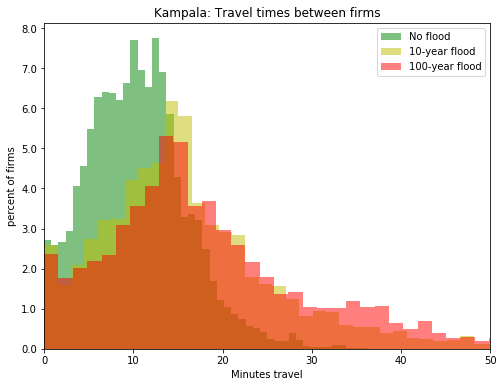

In [167]:
# Histogram of post-flood travel times between firms
bins = 50

fig,ax = plt.subplots(figsize=[8,6])
ax.hist(travel_times_base,color='g',alpha=0.5,density=True,bins=bins)
ax.hist(travel_times_10,color='y',alpha=0.5,density=True,bins=bins)
#ax.hist(travel_times_50,color='',alpha=0.5,density=True,bins=100)
ax.hist(travel_times_100_test,color='r',alpha=0.5,density=True,bins=bins)
plt.title('Kampala: Travel times between firms')
plt.ylabel('percent of firms')
plt.legend(['No flood','10-year flood','100-year flood'])
plt.xlabel('Minutes travel');

plt.xlim(0,50)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

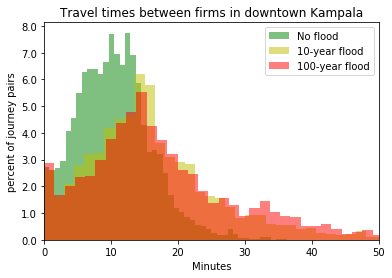

In [236]:
# Histogram of post-flood travel times between firms
bins = 50

fig,ax = plt.subplots(figsize=[6,4])
ax.hist(travel_times_base,color='g',alpha=0.5,density=True,bins=bins)
ax.hist(travel_times_10,color='y',alpha=0.5,density=True,bins=bins)
#ax.hist(travel_times_50,color='',alpha=0.5,density=True,bins=100)
ax.hist(travel_times_100,color='r',alpha=0.5,density=True,bins=bins)
plt.title('Travel times between firms in downtown Kampala')
plt.ylabel('percent of journey pairs')
plt.legend(['No flood','10-year flood','100-year flood'])
plt.xlabel('Minutes');

plt.xlim(0,50)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

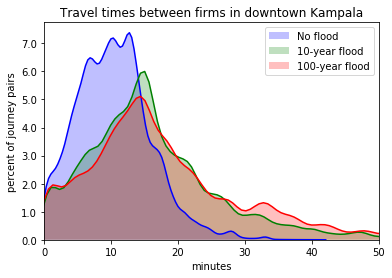

In [233]:
bw = 'scott'
fig,ax = plt.subplots(figsize=[6,4])

sns.kdeplot(travel_times_base,ax = ax, color = 'b', shade=True,bw=bw)
sns.kdeplot(travel_times_10, ax=ax, color='g',shade=True,bw=bw)
#sns.kdeplot(travel_times_50, ax=ax, color='y',shade=True)
sns.kdeplot(travel_times_100, ax=ax, color='r',shade=True,bw=bw)

ax.set_title('Travel times between firms in downtown Kampala')
plt.legend(['No flood','10-year flood','100-year flood'])
ax.set(xlabel="minutes", ylabel='percent of journey pairs');
plt.xlim(0,50)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [170]:
baseline_mean = travel_times_base.mean()
flood_10_mean = travel_times_10.mean()
flood_50_mean = travel_times_50.mean()
flood_100_mean = travel_times_100.mean()


In [171]:
change_df = pd.DataFrame({"mean times":[baseline_mean, flood_10_mean, flood_100_mean]},index=
                        ['no flood','10-year flood','100-year flood'])

In [172]:
change_df['percent difference'] = (change_df['mean times'] - change_df['mean times'][0]) / change_df['mean times'][0] * 100
change_df

,mean times,percent difference
no flood,10.437851,0.000000
10-year flood,16.056173,53.826420
100-year flood,17.624052,68.847508


In [180]:
baseline_OD_firms_DF = pd.DataFrame(baseline_OD_firms)
flood_OD_firms_10yr_df = pd.DataFrame(flood_OD_firms_10yr)
flood_OD_firms_50yr_df = pd.DataFrame(flood_OD_firms_50yr)
flood_OD_firms_100yr_df = pd.DataFrame(flood_OD_firms_100yr)

In [181]:
baseline_mean = baseline_OD_firms_DF.mean(axis=1)
flood_10yr_mean = flood_OD_firms_10yr_df[flood_OD_firms_10yr_df < 999999].mean(axis=1)
flood_50yr_mean = flood_OD_firms_50yr_df[flood_OD_firms_50yr_df < 999999].mean(axis=1)
flood_100yr_mean = flood_OD_firms_100yr_df[flood_OD_firms_100yr_df < 999999].mean(axis=1)


In [182]:
mean_times_by_firm = pd.DataFrame({'baseline_mean' : baseline_OD_firms_DF.mean(axis=1),
                                  'flood_10yr_mean' : flood_OD_firms_10yr_df[flood_OD_firms_10yr_df < 999999].mean(axis=1),
                                  'flood_50yr_mean' : flood_OD_firms_50yr_df[flood_OD_firms_50yr_df < 999999].mean(axis=1),
                                  'flood_100yr_mean' : flood_OD_firms_100yr_df[flood_OD_firms_100yr_df < 999999].mean(axis=1)})

In [183]:
def percent_change(changed, original):
    return (changed - original)/original * 100

mean_times_by_firm['diff_10'] = percent_change(mean_times_by_firm.flood_10yr_mean, mean_times_by_firm.baseline_mean)
mean_times_by_firm['diff_50'] = percent_change(mean_times_by_firm.flood_50yr_mean, mean_times_by_firm.baseline_mean)
mean_times_by_firm['diff_100'] = percent_change(mean_times_by_firm.flood_100yr_mean, mean_times_by_firm.baseline_mean)

In [184]:
mean_times_by_firm.head()

,baseline_mean,flood_10yr_mean,flood_50yr_mean,flood_100yr_mean,diff_10,diff_50,diff_100
0,481.707436,747.453261,798.272104,800.368868,55.167474,65.717206,66.152483
1,545.153380,836.380700,997.381427,990.358828,53.421171,82.954277,81.666090
2,456.449555,631.367893,670.726377,664.760967,38.321505,46.944250,45.637335
3,780.678131,1197.742391,1243.708643,1228.985721,53.423331,59.311321,57.425406
4,521.487917,837.308113,1163.926214,1159.423359,60.561364,123.193324,122.329861


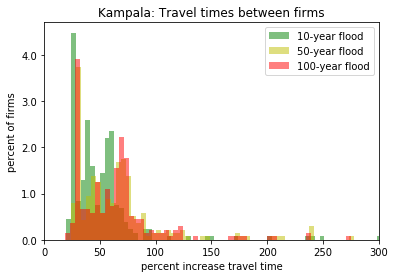

In [185]:
# Histogram of post-flood travel times between firms
bins = 100

fig,ax = plt.subplots(figsize=[6,4])
ax.hist(mean_times_by_firm.diff_10,color='g',alpha=0.5,density=True,bins=bins)
ax.hist(mean_times_by_firm.diff_50,color='y',alpha=0.5,density=True,bins=bins)
ax.hist(mean_times_by_firm.diff_100,color='r',alpha=0.5,density=True,bins=bins)
plt.title('Kampala: Travel times between firms')
plt.ylabel('percent of firms')
plt.legend(['10-year flood','50-year flood','100-year flood'])
plt.xlabel('percent increase travel time');

plt.xlim(0,300)

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

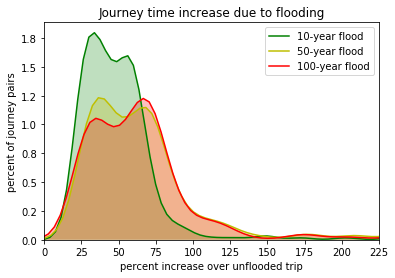

In [212]:
f,ax = plt.subplots(figsize=[6,4])

cols_to_show=['diff_10','diff_50','diff_100']
cols = ['g','y','r']

for n, column in enumerate(mean_times_by_firm[cols_to_show]):
    sns.kdeplot(mean_times_by_firm[column],shade=True,color=cols[n])
    
ax.set_title('Journey time increase due to flooding')
plt.legend(cols_to_show)
plt.legend(['10-year flood','50-year flood','100-year flood'])
plt.xlim(0,225)

ax.set(xlabel="percent increase over unflooded trip", ylabel='percent of journey pairs');

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [192]:
n_firms = mean_times_by_firm.shape[0]

sum(mean_times_by_firm.diff_50 < 100)


272

In [193]:
d25 = sum(mean_times_by_firm.diff_10 < 25)
d50 = sum(mean_times_by_firm.diff_10 < 50)
d75 = sum(mean_times_by_firm.diff_10 < 75)
d100 = sum(mean_times_by_firm.diff_10 < 100)
d300 = sum(mean_times_by_firm.diff_10 < 300)

In [51]:
pd.DataFrame()

""


In [199]:
return_period = 'diff_10'

threshold1 = 25
threshold2 = 50
threshold3 = 100
threshold4 = 300

print("Number of firms:")
print("Travel times increase up to {}%: {}".format(threshold1, sum((mean_times_by_firm[return_period] > 0) & 
                                                    (mean_times_by_firm[return_period] < threshold1))))
print("Travel times increase up to {}%: {}".format(threshold2, sum((mean_times_by_firm[return_period] > threshold1) & 
                                                    (mean_times_by_firm[return_period] < threshold2))))
print("Travel times increase up to {}%: {}".format(threshold3, sum((mean_times_by_firm[return_period] > threshold2) & 
                                                    (mean_times_by_firm[return_period] < threshold3))))
print("Travel times increase more than {}%: {}".format(threshold3, sum((mean_times_by_firm[return_period] > threshold3) & 
                                                    (mean_times_by_firm[return_period] < threshold4))))

Number of firms:
Travel times increase up to 25%: 13
Travel times increase up to 50%: 145
Travel times increase up to 100%: 114
Travel times increase more than 100%: 10


In [195]:
mean_times_by_firm.to_csv('data/mean_times_by_firm.csv')

In [200]:
return_period = 'diff_50'

print("Percent of firms:")
print("Travel times increase up to {}%: {:.1f}".format(threshold1, sum((mean_times_by_firm[return_period] > 0) & 
                                                    (mean_times_by_firm[return_period] < threshold1))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold2, sum((mean_times_by_firm[return_period] > threshold1) & 
                                                    (mean_times_by_firm[return_period] < threshold2))/ n_firms * 100))
print("Travel times increase up to {}%: {:.1f}".format(threshold3, sum((mean_times_by_firm[return_period] > threshold2) & 
                                                    (mean_times_by_firm[return_period] < threshold3))/ n_firms * 100))
print("Travel times increase more than {}%: {:.1f}".format(threshold3, sum((mean_times_by_firm[return_period] > threshold3) & 
                                                    (mean_times_by_firm[return_period] < threshold4))/ n_firms * 100))

Percent of firms:
Travel times increase up to 25%: 0.7
Travel times increase up to 50%: 36.8
Travel times increase up to 100%: 39.7
Travel times increase more than 100%: 9.8


In [55]:
pd.DataFrame(data={'Up to 25% increase':sum(mean_times_by_firm.diff_10 < 25),
              'Travel times increase 25% to 50%':sum((mean_times_by_firm.diff_10 > 25) & (mean_times_by_firm.diff_10 < 50)),
              'Travel times increase 50% to 75%':sum((mean_times_by_firm.diff_10 > 50) & (mean_times_by_firm.diff_10 < 75)),
              'Up to 100% increase':sum((mean_times_by_firm.diff_10 > 75) & (mean_times_by_firm.diff_10 < 100)),
               'More than 100% increase':sum((mean_times_by_firm.diff_10 > 100) & (mean_times_by_firm.diff_10 < 400)),
                  }, index=['Travel time change by number firms']).T

,Travel time change by number firms
Up to 25% increase,124
Travel times increase 25% to 50%,143
Travel times increase 50% to 75%,25
Up to 100% increase,2
More than 100% increase,13


In [56]:
pd.DataFrame(data={'Up to 25% increase':sum(mean_times_by_firm.diff_10 < 25) / n_firms * 100,
              'Travel times increase 25% to 50%':sum((mean_times_by_firm.diff_10 > 25) & (mean_times_by_firm.diff_10 < 50)) / n_firms * 100,
              'Travel times increase 50% to 75%':sum((mean_times_by_firm.diff_10 > 50) & (mean_times_by_firm.diff_10 < 75)) / n_firms * 100,
              'Up to 100% increase':sum((mean_times_by_firm.diff_10 > 75) & (mean_times_by_firm.diff_10 < 10)) / n_firms * 100,
               'More than 100% increase':sum((mean_times_by_firm.diff_10 > 100) & (mean_times_by_firm.diff_10 < 400)) / n_firms * 100,
                  }, index=['Travel time change by percent firms']).T

,Travel time change by percent firms
Up to 25% increase,40.390879
Travel times increase 25% to 50%,46.579805
Travel times increase 50% to 75%,8.143322
Up to 100% increase,0.000000
More than 100% increase,4.234528


#### 10. Travel times grid to hospitals

In [313]:
grid_clipped = gpd.sjoin(grid,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


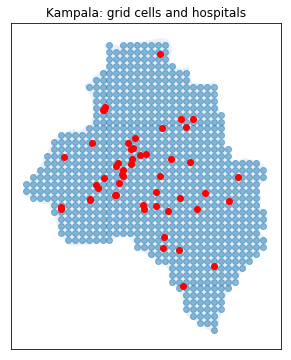

In [315]:
ax = boundary_GDF.plot(alpha = 0.1, figsize=[6,6])
#show(raster, ax = ax)

grid_clipped.plot(ax=ax,alpha=0.5)
POIs_health.plot(ax=ax,color='r')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.title('Kampala: grid cells and hospitals');

In [316]:
baseline_OD_hosp = gn.calculate_OD(G3, list(grid_clipped.NN), list(POIs_health.NN), fail_value, weight='time')

In [317]:
flood_OD_hosp_access_10yr = gn.calculate_OD(G_flood10, list(grid_clipped.NN), list(POIs_health.NN), fail_value, weight='time')
flood_OD_hosp_access_50yr = gn.calculate_OD(G_flood50, list(grid_clipped.NN), list(POIs_health.NN), fail_value, weight='time')
flood_OD_hosp_access_100yr = gn.calculate_OD(G_flood100, list(grid_clipped.NN), list(POIs_health.NN), fail_value, weight='time')

In [318]:
flood_OD_hosp_access_10yr[flood_OD_hosp_access_10yr > 10000] = np.nan
flood_OD_hosp_access_50yr[flood_OD_hosp_access_50yr > 10000] = np.nan
flood_OD_hosp_access_100yr[flood_OD_hosp_access_100yr > 10000] = np.nan

In [319]:
baseline_df_hosp = pd.DataFrame(baseline_OD_hosp/60)
flood_df_hosp_10 = pd.DataFrame(flood_OD_hosp_access_10yr/60)
flood_df_hosp_50 = pd.DataFrame(flood_OD_hosp_access_50yr/60)
flood_df_hosp_100 = pd.DataFrame(flood_OD_hosp_access_100yr/60)

In [320]:
time_to_nearest_hospital = pd.DataFrame({"Baseline":baseline_df_hosp.min(axis = 1),
              "Flood_10":flood_df_hosp_10.min(axis=1),
              "Flood_50":flood_df_hosp_50.min(axis=1),
              "Flood_100":flood_df_hosp_100.min(axis=1)})

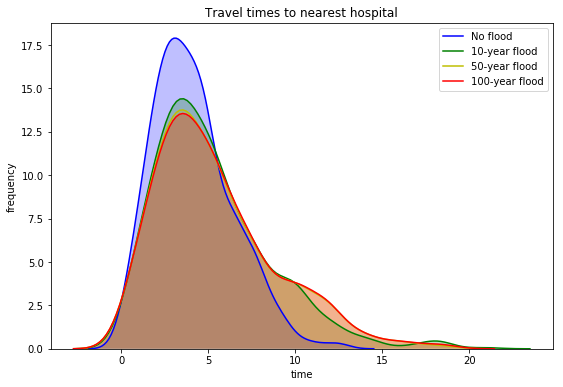

In [324]:
f,ax = plt.subplots(figsize=[9,6])
cols = ['b','g','y','r']

for n, column in enumerate(time_to_nearest_hospital.columns):
    sns.kdeplot(time_to_nearest_hospital[column],shade=True,color=cols[n])

ax.set_title('Travel times to nearest hospital')
plt.legend(['No flood','10-year flood','50-year flood','100-year flood'])
#ax.set_yticklabels([])
ax.set(xlabel="time", ylabel='frequency')

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [323]:
time_to_hospital_mean = pd.DataFrame({"Baseline":baseline_df_hosp.mean(axis = 1),
              "Flood_10":flood_df_hosp_10.mean(axis=1),
              "Flood_50":flood_df_hosp_50.mean(axis=1),
              "Flood_100":flood_df_hosp_100.mean(axis=1)})

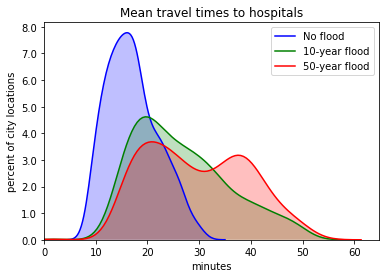

In [374]:
f,ax = plt.subplots(figsize=[6,4])
cols = ['b','g','r']
cols_to_show = ['Baseline','Flood_10','Flood_50']

for n, column in enumerate(cols_to_show):
    sns.kdeplot(time_to_hospital_mean[column],shade=True,color=cols[n])

ax.set_title('Mean travel times to hospitals')
plt.legend(['No flood','10-year flood','50-year flood'])
plt.xlim(0)
#ax.set_yticklabels([])
ax.set(xlabel="minutes", ylabel='percent of city locations')

ticks = ax.get_yticks()*100
ticks = [round(n,1) for n in (list(ticks))]
ax.set_yticklabels(ticks);

In [340]:
time_to_hospital_mean.Flood_50.isnull().sum() / time_to_hospital_mean.shape[0] * 100

7.770700636942675

In [342]:
time_to_hospital_mean.columns

Index(['Baseline', 'Flood_10', 'Flood_50', 'Flood_100'], dtype='object')

In [335]:
for column in time_to_hospital_mean.columns:
    print("Mean time to hospital ({}): {:.1f}".format(column, time_to_hospital_mean[column].mean()))

Mean time to hospital (Baseline): 17.1
Mean time to hospital (Flood_10): 26.6
Mean time to hospital (Flood_50): 29.7
Mean time to hospital (Flood_100): 29.7


In [345]:
def percent_change(changed, original):
    return (changed - original)/original * 100

mean_times_by_location = pd.DataFrame()
mean_times_by_location['diff_10'] = percent_change(time_to_hospital_mean.Flood_10, time_to_hospital_mean.Baseline)
mean_times_by_location['diff_50'] = percent_change(time_to_hospital_mean.Flood_50, time_to_hospital_mean.Baseline)
mean_times_by_location['diff_100'] = percent_change(time_to_hospital_mean.Flood_100, time_to_hospital_mean.Baseline)

In [349]:
grid_clipped.shape

(785, 12)

In [371]:
print("Baseline - Number of city locations for which travel time to hospital exceeds 30 minutes: {}".format(
      time_to_hospital_mean.Baseline[time_to_hospital_mean.Baseline > 30].count()))

print("Percent of city locations for which travel time to hospital  exceeds 30 minutes: {:.1f}".format(
      time_to_hospital_mean.Baseline[time_to_hospital_mean.Baseline > 30].count()
       / time_to_hospital_mean.Baseline.shape[0] * 100))

Baseline - Number of city locations for which travel time to hospital exceeds 30 minutes: 4
Percent of city locations for which travel time to hospital  exceeds 30 minutes: 0.5


In [372]:
print("10 year flood - Number of city locations for which travel time to hospital exceeds 30 minutes: {}".format(
      time_to_hospital_mean.Flood_10[time_to_hospital_mean.Flood_10 > 30].count()))

print("Percent of city locations for which travel time to hospital  exceeds 30 minutes: {:.1f}".format(
      time_to_hospital_mean.Flood_10[time_to_hospital_mean.Flood_10 > 30].count()
       / time_to_hospital_mean.Flood_10.shape[0] * 100))

10 year flood - Number of city locations for which travel time to hospital exceeds 30 minutes: 237
Percent of city locations for which travel time to hospital  exceeds 30 minutes: 30.2


In [370]:
print("50 year flood - Number of city locations for which travel time to hospital exceeds 30 minutes: {}".format(
      time_to_hospital_mean.Flood_50[time_to_hospital_mean.Flood_50 > 30].count()))

print("Percent of city locations for which travel time to hospital  exceeds 30 minutes: {:.1f}".format(
      time_to_hospital_mean.Flood_50[time_to_hospital_mean.Flood_50 > 30].count()
       / time_to_hospital_mean.Flood_50.shape[0] * 100))

50 year flood - Number of city locations for which travel time to hospital exceeds 30 minutes: 342
Percent of city locations for which travel time to hospital  exceeds 30 minutes: 43.6


In [ ]:
print("Number of city locations for which travel time to hospital exceeds 30 minutes: {}".format(
      mean_times_by_location.diff_50[mean_times_by_location.diff_50 > 100].count()))

print("Percent of city locations for which travel time to hospital doubles or more: {:.1f}".format(
      mean_times_by_location.diff_50[mean_times_by_location.diff_50 > 100].count()
       / mean_times_by_location.shape[0] * 100))

In [355]:
135/785

0.17197452229299362

In [171]:
change_df = pd.DataFrame({"mean times":[baseline_mean, flood_10_mean, flood_100_mean]},index=
                        ['no flood','10-year flood','100-year flood'])

In [172]:
change_df['percent difference'] = (change_df['mean times'] - change_df['mean times'][0]) / change_df['mean times'][0] * 100
change_df

,mean times,percent difference
no flood,10.437851,0.000000
10-year flood,16.056173,53.826420
100-year flood,17.624052,68.847508
